# Training the mask classification model and evaluating the pipeline

We train a MobileNet model to perform mask/no_mask classification, and evaluate the complete pipeline (i.e. face detection followed by mask classification).

In [49]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.mobilenet import preprocess_input

import keras 

from sklearn import metrics 
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import itertools
import random
from collections import namedtuple

## Setup

In [42]:
target_size = (112,112)
batch_size = 32
lr = 0.01
n_epochs = 2 

model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

data_dir = Path('../data')

performance_plots_dir = Path('img')
performance_plots_dir.mkdir(exist_ok=True)

prediction_plot_dir = Path('../data/collected_images/predictions')
plot_dir_correct = prediction_plot_dir / 'all_correct'
plot_dir_correct.mkdir(exist_ok=True, parents=True)
plot_dir_mistake = prediction_plot_dir / 'mistake'
plot_dir_mistake.mkdir(exist_ok=True, parents=True)

## Create train/validation/test generators

The unmasked and artificially masked images from VGGFace2 are divided into a training and validation set. 

In [3]:
train_frame = pd.DataFrame(columns=['image', 'label'])
val_frame = pd.DataFrame(columns=['image', 'label'])

train_path = data_dir / 'train'
train_path_masked = train_path / 'masked'
train_path_not_masked = train_path / 'not_masked'

train_pct_artificial_masked = 0.7

## divide artificial masked over train/validation
artificial_masked_fns = list(train_path_masked.glob('*.jpg'))
for fn in artificial_masked_fns[:int(train_pct_artificial_masked*len(artificial_masked_fns))]:
    train_frame.loc[len(train_frame)] = [fn, 'with_mask']  
for fn in artificial_masked_fns[int(train_pct_artificial_masked*len(artificial_masked_fns)):]:
    val_frame.loc[len(val_frame)] = [fn, 'with_mask']
    
    
## divide not_masked over train/validation
not_masked_fns = list(train_path_not_masked.glob('*.jpg'))
for fn in not_masked_fns[:int(train_pct_artificial_masked*len(not_masked_fns))]:
    train_frame.loc[len(train_frame)] = [fn, 'no_mask']  
for fn in not_masked_fns[int(train_pct_artificial_masked*len(not_masked_fns)):]:
    val_frame.loc[len(val_frame)] = [fn, 'no_mask']

In [55]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_frame.image = train_frame.image.astype(str)
train_generator = train_datagen.flow_from_dataframe(train_frame,
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    x_col='image',
                                                    y_col='label')

Found 3458 validated image filenames belonging to 2 classes.


In [56]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_frame.image = val_frame.image.astype(str)
val_generator = val_datagen.flow_from_dataframe(val_frame, 
                                                shuffle=False,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                x_col='image',
                                                y_col='label')

Found 1483 validated image filenames belonging to 2 classes.


The real masked data will be split over a second validation set and a test set.  
After each epoch the classifier will be executed on the boudning boxes detected by the face detector.  
The resulting labeled bounding boxes are then compared to the ground truth face bounding boxes and their true labels.

In [4]:
# we need both the ground truth and detector bounding boxes to evaluate the IoU 
detector_bboxes = pd.read_csv(data_dir / 'detector_annotations.csv')
ground_truth_boxes = pd.read_csv(data_dir / 'image_annotations.csv')

real_image_path = data_dir / 'collected_images' / 'original'
real_image_fns = list(sorted(real_image_path.glob('*.jpg')))

# this directory already contains cropped faces that correspond to the detector's bounding boxes,
# these will be used as input to the classifier
crop_dir = data_dir / 'collected_images' / 'cropped_faces' 

random.seed(2362)
random.shuffle(real_image_fns)

validation_pct_real = 0.5

# each line in these frames will correspond to one bounding box detected by the face detector
validation_real = real_image_fns[:int(validation_pct_real*len(real_image_fns))]
val_frame_real = pd.DataFrame(columns=['original_image','bbox_id','x','y','w','h','image','class'])
for fn in validation_real:
    detector_bboxes_fn = detector_bboxes[detector_bboxes.img == fn.name]
    for row_idx in range(detector_bboxes_fn.shape[0]):
        cur_row = detector_bboxes_fn.iloc[row_idx]
        val_frame_real.loc[len(val_frame_real)] = [fn.name,row_idx,cur_row.x, cur_row.y, cur_row.w, cur_row.h, crop_dir / (fn.stem + '_' + str(row_idx) + '.jpg'),'none']
     
test_real = real_image_fns[int(validation_pct_real*len(real_image_fns)):]
test_frame_real = pd.DataFrame(columns=['original_image','bbox_id','x','y','w','h','image','class'])
for fn in test_real:
    detector_bboxes_fn = detector_bboxes[detector_bboxes.img == fn.name]
    for row_idx in range(detector_bboxes_fn.shape[0]):
        cur_row = detector_bboxes_fn.iloc[row_idx]
        test_frame_real.loc[len(test_frame_real)] = [fn.name,row_idx,cur_row.x, cur_row.y, cur_row.w, cur_row.h, crop_dir / (fn.stem + '_' + str(row_idx) + '.jpg'),'none']        

In [57]:
val_datagen_real = ImageDataGenerator(preprocessing_function=preprocess_input)
val_frame_real.image = val_frame_real.image.astype(str)
val_generator_real = val_datagen_real.flow_from_dataframe(val_frame_real, 
                                                shuffle=False,
                                                target_size=target_size,
                                                x_col='image')

Found 255 validated image filenames belonging to 1 classes.


/home/toon/mask_env_37/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [58]:
test_datagen_real = ImageDataGenerator(preprocessing_function=preprocess_input)
test_frame_real.image = test_frame_real.image.astype(str)
test_generator_real = test_datagen_real.flow_from_dataframe(test_frame_real, 
                                                shuffle=False,
                                                target_size=target_size,
                                                x_col='image')

Found 254 validated image filenames belonging to 1 classes.


/home/toon/mask_env_37/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Defining the model

MobileNet base with 1 fully connected layers on top and one final layer with sigmoid activation that outputs predictions.  
Only the last layers are trained, others are frozen.

In [51]:
base_model = MobileNet(weights='imagenet',include_top=False, input_shape=(target_size[0],target_size[1],3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x) 
preds = Dense(1,activation='sigmoid')(x)

model = Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:-4]:
    layer.trainable = False

## Setting up train/validation/test generators

## Callback to report performance on real and artificial data separately

In [12]:
def bb_intersection_over_union(boxA, boxB):
    '''
    Computes the IoU between two bounding boxes
    from https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    '''
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [13]:
def compute_image_score(true_boxes, true_labels, pred_boxes, pred_labels, pred_scores):
    """
    Computes performance statistics for a single image.   
    
    """
    ordered_gt_labels = []
    ordered_pred_scores = []
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    n_masked_faces_that_dont_exist = 0
    n_non_masked_faces_that_dont_exist = 0
 
    n_masked_labeled_as_both = 0
    n_non_masked_labeled_as_both = 0
    
    n_masked_correctly_detected_multiple_times = 0
    n_masked_wrongly_detected_multiple_times = 0
    
    n_non_masked_wrongly_detected_multiple_times = 0
    n_non_masked_correctly_detected_multiple_times = 0
    
    n_non_masked_not_identified = 0
    n_masked_not_identified = 0
    
    # first we check for each ground truth bounding box whether it was detected
    for gt_box, gt_label in zip(true_boxes, true_labels):
        
        times_found_correct_label = 0
        times_found_incorrect_label = 0 
        for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores): 
            iou = bb_intersection_over_union(gt_box, pred_box)
            
            if iou > 0.5:
                ordered_gt_labels.append(gt_label)
                ordered_pred_scores.append(pred_score)
            
            if iou >= 0.5 and gt_label == pred_label:
                times_found_correct_label += 1
            elif iou >= 0.5 and gt_label != pred_label:
                times_found_incorrect_label += 1
            
        times_found_total = times_found_correct_label + times_found_incorrect_label
        
        if gt_label == 1:
            
            if times_found_total == 0:
                n_masked_not_identified += 1
            elif times_found_correct_label == 0 and times_found_incorrect_label > 0:
                fn += 1
                n_masked_wrongly_detected_multiple_times += 1
            elif times_found_correct_label > 0 and times_found_incorrect_label == 0:
                tp += 1
                n_masked_correctly_detected_multiple_times += times_found_correct_label - 1
            elif times_found_correct_label > 0 and times_found_incorrect_label > 0:
                n_masked_labeled_as_both += 1
                
        elif gt_label == 0:
            
            if times_found_total == 0:
                n_non_masked_not_identified += 1
            elif times_found_correct_label == 0 and times_found_incorrect_label > 0:
                fp += 1
                n_non_masked_wrongly_detected_multiple_times += times_found_incorrect_label - 1
            elif times_found_correct_label > 0 and times_found_incorrect_label == 0:
                tn += 1
                n_non_masked_correctly_detected_multiple_times += times_found_correct_label - 1
            elif times_found_correct_label > 0 and times_found_incorrect_label > 0:
                n_non_masked_labeled_as_both += 1
                
   
    # we also have to check for detected bounding boxes that do not overlap with any ground truth bounding box
    for pred_box, pred_label in zip(pred_boxes, pred_labels):
        found = False
        for gt_box, gt_label in zip(true_boxes, true_labels):
            iou = bb_intersection_over_union(gt_box, pred_box)
            if iou > 0.5:
                found = True
                break
                
        if not found:
            
            if pred_label == 1:
                n_masked_faces_that_dont_exist += 1
            else:
                n_non_masked_faces_that_dont_exist += 1
    
    Stats = namedtuple('Stats', ['tp', 'fp', 'tn', 'fn', 
                             'n_masked_not_identified',
                             'n_non_masked_not_identified',
                             'n_masked_faces_that_dont_exist',
                             'n_non_masked_faces_that_dont_exist', 
                             'n_masked_labeled_as_both',
                             'n_non_masked_labeled_as_both',
                             'n_masked_correctly_detected_multiple_times',
                             'n_masked_wrongly_detected_multiple_times',
                             'n_non_masked_wrongly_detected_multiple_times',
                             'n_non_masked_correctly_detected_multiple_times'])
    return Stats(tp,fp,tn,fn,
                 n_masked_not_identified,
                 n_non_masked_not_identified,
                 n_masked_faces_that_dont_exist,
                 n_non_masked_faces_that_dont_exist,
                 n_masked_labeled_as_both,
                 n_non_masked_labeled_as_both,
                 n_masked_correctly_detected_multiple_times,
                 n_masked_wrongly_detected_multiple_times,
                 n_non_masked_wrongly_detected_multiple_times,
                 n_non_masked_correctly_detected_multiple_times), ordered_gt_labels, ordered_pred_scores

In [14]:
def plot_img(fn, true_boxes, true_labels, pred_boxes, pred_labels):
    img = cv2.imread(str(fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure()
    plt.imshow(img/255)
    
    for x1, y1, x2, y2 in true_boxes:
        rect = plt.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor='black',facecolor='none')
        plt.gca().add_patch(rect)
        
    for (x1, y1, x2, y2), predicted_mask in zip(pred_boxes, pred_labels):
        rect = plt.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3, edgecolor='green' if predicted_mask else 'red',facecolor='none')
        plt.gca().add_patch(rect)
   
    output_dir = plot_dir_correct if true_labels == pred_labels else plot_dir_mistake
    plt.axis('off')
    plt.savefig(output_dir / fn.name, bbox_inches='tight', pad_inches=0)
    plt.close()

In [40]:
def compute_validation_statistics(model, val_gen, val_df, plot=False):
    
    pred = model.predict_generator(val_gen)
    pred_df = pd.DataFrame({'img' : val_gen.filenames,
                            'pred' : np.squeeze(pred)})

    # from the cropped img name (e.g. 100_0.jpg) to the original image name (e.g. 100.jpg)
    pred_df['original_image'] = pred_df.img.apply(lambda x: x.split('/')[-1].split('_')[0] + '.jpg') 
    
    # extract the bbox id, e.g. cropped image 100_0.jpg corresponds to 0th extracted face bbox
    # we need this id because the ground truth annotations reference them 
    pred_df['bbox_id'] = pred_df.img.apply(lambda x: int(x.split('/')[-1].split('_')[1].split('.')[0]))

    pred_df['predicted_class'] = pred_df.pred.apply(lambda x: 1 if x > 0.5 else 0)

    # merging with val_df to get one dataframe with both the class predictions and detector bounding box coordinates
    pred_df = pred_df.merge(val_df, left_on=['original_image', 'bbox_id'], right_on=['original_image', 'bbox_id'])

    tp_tot = 0
    fp_tot = 0
    fn_tot = 0
    tn_tot = 0

    n_masked_faces_that_dont_exist = 0
    n_non_masked_faces_that_dont_exist = 0
    n_masked_labeled_as_both = 0
    n_non_masked_labeled_as_both = 0
    n_masked_correctly_detected_multiple_times = 0
    n_masked_wrongly_detected_multiple_times = 0
    n_non_masked_wrongly_detected_multiple_times = 0
    n_non_masked_correctly_detected_multiple_times = 0
    n_masked_not_identified = 0
    n_non_masked_not_identified = 0
    
    all_gt_labels = []
    matched_pred_scores = []

    val_img_ids = set(val_df.original_image)
    for val_img_id in val_img_ids:
        
        # first collect ground truth bounding boxes and labels in a nicer format
        img_ground_truth = ground_truth_boxes[ground_truth_boxes.img == val_img_id]
        true_labels = []
        true_boxes = []
        for idx, row in img_ground_truth.iterrows():
            true_labels.append(1 if row['class'] == 'with_mask' else 0)
            true_boxes.append((row.x, row.y, row.x + row.w, row.y + row.h))

        # do the same for the predictions
        img_pred = pred_df[pred_df.original_image == val_img_id]
        pred_labels = []
        pred_boxes = []
        pred_scores = []
        for idx, row in img_pred.iterrows():
            pred_labels.append(row.predicted_class)
            pred_boxes.append((row.x, row.y, row.x + row.w, row.y + row.h))
            pred_scores.append(row.pred)

        if plot:
            plot_img(data_dir / 'collected_images' / 'original' / val_img_id, true_boxes, true_labels, pred_boxes, pred_labels)
       
        stats, cur_gt, cur_scores = compute_image_score(true_boxes, true_labels, pred_boxes, pred_labels, pred_scores)

        all_gt_labels.extend(cur_gt)
        matched_pred_scores.extend(cur_scores)
        
        tp_tot += stats.tp
        fp_tot += stats.fp
        fn_tot += stats.fn
        tn_tot += stats.tn
        
        n_masked_faces_that_dont_exist += stats.n_masked_faces_that_dont_exist
        n_non_masked_faces_that_dont_exist += stats.n_non_masked_faces_that_dont_exist
        n_masked_labeled_as_both += stats.n_masked_labeled_as_both
        n_non_masked_labeled_as_both += stats.n_non_masked_labeled_as_both
        n_masked_correctly_detected_multiple_times += stats.n_masked_correctly_detected_multiple_times
        n_masked_wrongly_detected_multiple_times += stats.n_masked_wrongly_detected_multiple_times
        n_non_masked_wrongly_detected_multiple_times += stats.n_non_masked_wrongly_detected_multiple_times
        n_non_masked_correctly_detected_multiple_times += stats.n_non_masked_correctly_detected_multiple_times
        n_masked_not_identified += stats.n_masked_not_identified
        n_non_masked_not_identified += stats.n_non_masked_not_identified
                
    
    print(f"\n====\nEvaluation of the face detector\n====")
    print(f"The detector found {n_masked_faces_that_dont_exist} masked faces that don't exist")
    print(f"The detector found {n_non_masked_faces_that_dont_exist} non-masked faces that don't exist")
    
    print(f"{n_masked_not_identified} masked faces were not identified by the detector")
    print(f"{n_non_masked_not_identified} non-masked faces were not identified by the detector\n")
    
    print("\n====\nEvaluation of the mask/no_mask classifier:\n====")
    print("On the ground truth-bounding boxes that were identified by the detector, we have the following stats: ")
    print(f"True positives: {tp_tot}")
    print(f"True negatives: {tn_tot}")
    print(f"False positives: {fp_tot}")    
    print(f"False negatives: {fn_tot}")
    acc = (tp_tot + tn_tot) / (tp_tot + tn_tot + fp_tot + fn_tot)
    print(f"Resulting in the following accuracy on the *detected* faces: {acc:.2f}\n")
    
          
    print("\n====\nGlobal evaluation:\n====")
    tnr = tn_tot / (tn_tot + fp_tot + n_non_masked_not_identified)
    print(f"TNR: {100*tnr:.1f}%, i.e. {100*tnr:.1f}% of the unmasked faces were detected")
    
    fnr = fn_tot / (tp_tot + fn_tot + n_masked_not_identified)
    print(f"FNR: {100*fnr:.1f}%, i.e. {100*fnr:.1f}% of masked faces were wrongly identified as unmasked faces")
    
    print(f"Additionally, {n_non_masked_faces_that_dont_exist} unmasked faces were detected for which there was no matching face in the ground truth")

    return acc, all_gt_labels, matched_pred_scores

In [16]:
class SubsetAccuracy(keras.callbacks.Callback):
    """
    We want to monitor accuracy in the validation set separately for real and artificial face masks.
    This callback will print this to the output, and store the values for each epoch.
    """
    
    def __init__(self, real_val_gen=None, real_val_df=None):
        self.real_val_gen = real_val_gen
        self.real_val_df = real_val_df
        self.cur_best_acc = 0
        
    def on_epoch_end(self, batch, logs={}):
        acc, _, _ = compute_validation_statistics(self.model, self.real_val_gen, self.real_val_df)
        
        if acc > self.cur_best_acc:
            self.model.save(model_dir / 'best.h5')
            self.cur_best_acc = acc
          
subset_acc = SubsetAccuracy(val_generator_real, val_frame_real)

## Compile and fit the model

In [17]:
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size

In [18]:
model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, epochs=n_epochs, validation_data=val_generator, validation_steps=step_size_val, callbacks=[subset_acc])

Epoch 1/2
108/108 [==============================] - 24s 224ms/step - loss: 0.2395 - accuracy: 0.9445 - val_loss: 3.9843e-05 - val_accuracy: 0.9905

====
Evaluation of the face detector
====
The detector found 9 masked faces that don't exist
The detector found 8 non-masked faces that don't exist
10 masked faces were not identified by the detector
11 non-masked faces were not identified by the detector


====
Evaluation of the mask/no_mask classifier:
====
On the ground truth-bounding boxes that were identified by the detector, we have the following stats: 
True positives: 92
True negatives: 128
False positives: 3
False negatives: 14
Resulting in the following accuracy on the *detected* faces: 0.93


====
Global evaluation:
====
TNR: 90.1%, i.e. 90.1% of the unmasked faces were detected
FNR: 12.1%, i.e. 12.1% of masked faces were wrongly identified as unmasked faces
Additionally, 8 unmasked faces were detected for which there was no matching face in the ground truth
Epoch 2/2
108/108 [=

## Inspect validation set performance statistics

In [19]:
best_model = keras.models.load_model(model_dir / 'best.h5')

In [20]:
val_pred = best_model.predict_generator(val_generator)

#### Helper functions

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_stats(true_labels, pred):
    pred_bin = [x > 0.5 for x in pred]
    acc = metrics.accuracy_score(true_labels, pred_bin)
    print(f"Accuracy = {acc:.3f}")

    cm = metrics.confusion_matrix(true_labels, pred_bin)
    plt.figure()
    plot_confusion_matrix(cm, ['not masked', 'masked'])
    plt.savefig(performance_plots_dir / 'confusion.png', bbox_inches='tight', pad_inches=0)
    
    fpr, tpr, thr = metrics.roc_curve(true_labels, pred)
    auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title(f'AUC = {auc:.3f}', size=15)
    plt.savefig(performance_plots_dir / 'roc.png', bbox_inches='tight', pad_inches=0)

## Performance on artificially masked images in validation set

Accuracy = 0.991


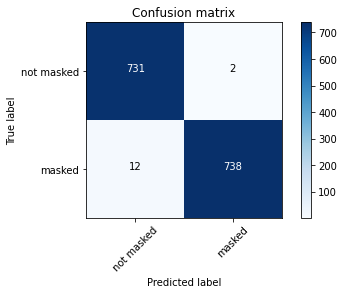

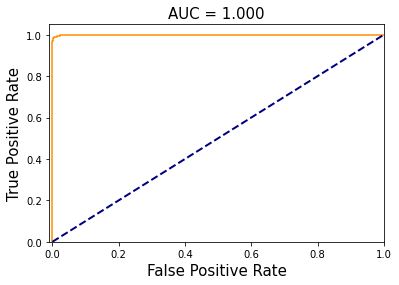

In [22]:
true_all = [1 if x == 'with_mask' else 0 for x in val_frame.label]
pred = [x[0] for x in val_pred]
print_stats(true_all, pred)

## Performance on real images in validation set

In [45]:
stats, gt_ordered, scores_ordered = compute_validation_statistics(best_model,val_generator_real, val_frame_real, plot=False)


====
Evaluation of the face detector
====
The detector found 9 masked faces that don't exist
The detector found 8 non-masked faces that don't exist
10 masked faces were not identified by the detector
11 non-masked faces were not identified by the detector


====
Evaluation of the mask/no_mask classifier:
====
On the ground truth-bounding boxes that were identified by the detector, we have the following stats: 
True positives: 92
True negatives: 128
False positives: 3
False negatives: 14
Resulting in the following accuracy on the *detected* faces: 0.93


====
Global evaluation:
====
TNR: 90.1%, i.e. 90.1% of the unmasked faces were detected
FNR: 12.1%, i.e. 12.1% of masked faces were wrongly identified as unmasked faces
Additionally, 8 unmasked faces were detected for which there was no matching face in the ground truth


The following are the confusion matrix and ROC for the mask/no_mask classifier on all ground truth faces that were detected by the face detector.

Accuracy = 0.929


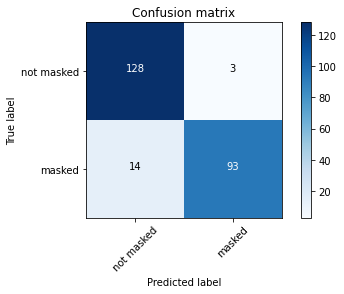

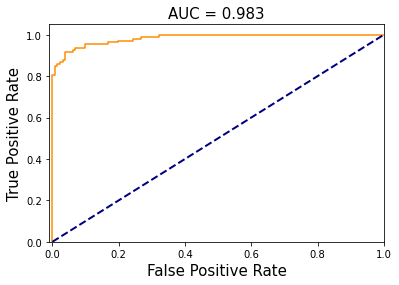

In [46]:
print_stats(gt_ordered, scores_ordered)

In [48]:
stats, gt_ordered, pred_ordered = compute_validation_statistics(best_model,test_generator_real, test_frame_real, plot=True)


====
Evaluation of the face detector
====
The detector found 1 masked faces that don't exist
The detector found 5 non-masked faces that don't exist
10 masked faces were not identified by the detector
5 non-masked faces were not identified by the detector


====
Evaluation of the mask/no_mask classifier:
====
On the ground truth-bounding boxes that were identified by the detector, we have the following stats: 
True positives: 97
True negatives: 128
False positives: 3
False negatives: 20
Resulting in the following accuracy on the *detected* faces: 0.91


====
Global evaluation:
====
TNR: 94.1%, i.e. 94.1% of the unmasked faces were detected
FNR: 15.7%, i.e. 15.7% of masked faces were wrongly identified as unmasked faces
Additionally, 5 unmasked faces were detected for which there was no matching face in the ground truth


Accuracy = 0.929


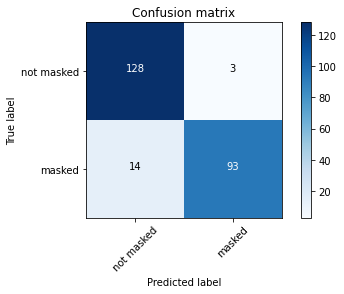

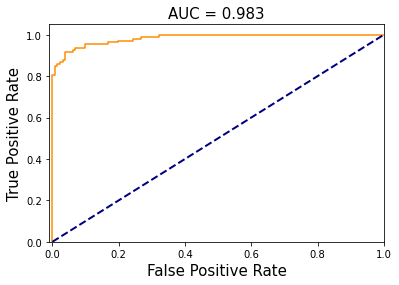

In [47]:
print_stats(gt_ordered, scores_ordered)

## Visualizing some good and bad predictions

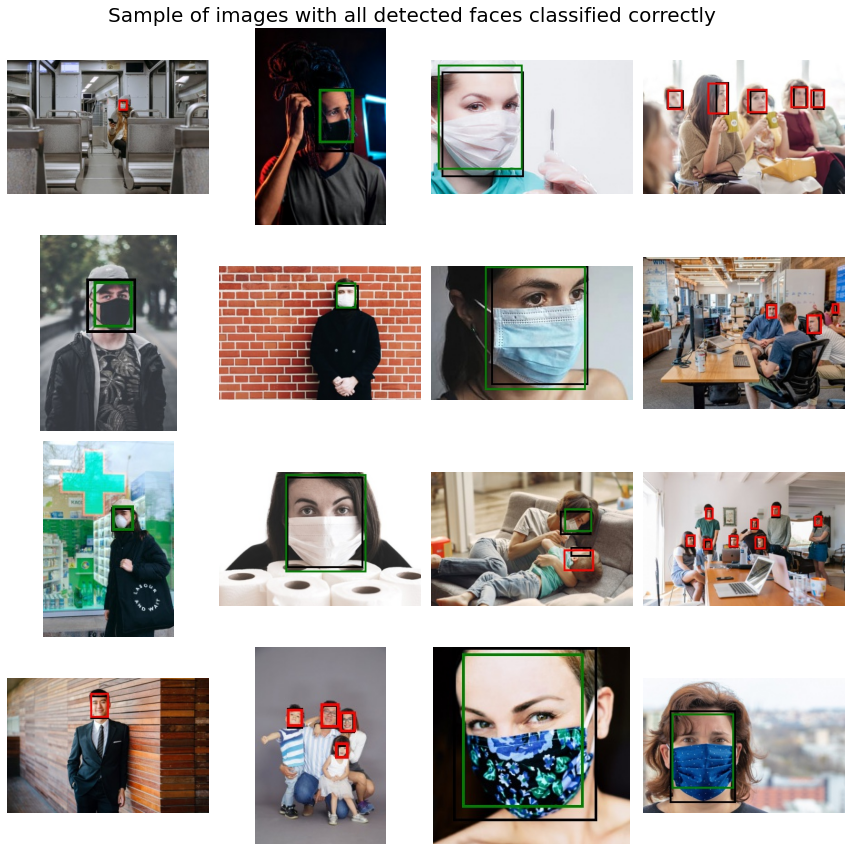

In [26]:
n_to_plot = 16
all_correct_pred = list(plot_dir_correct.glob('*.jpg'))
to_plot = random.sample(all_correct_pred,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with all detected faces classified correctly', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

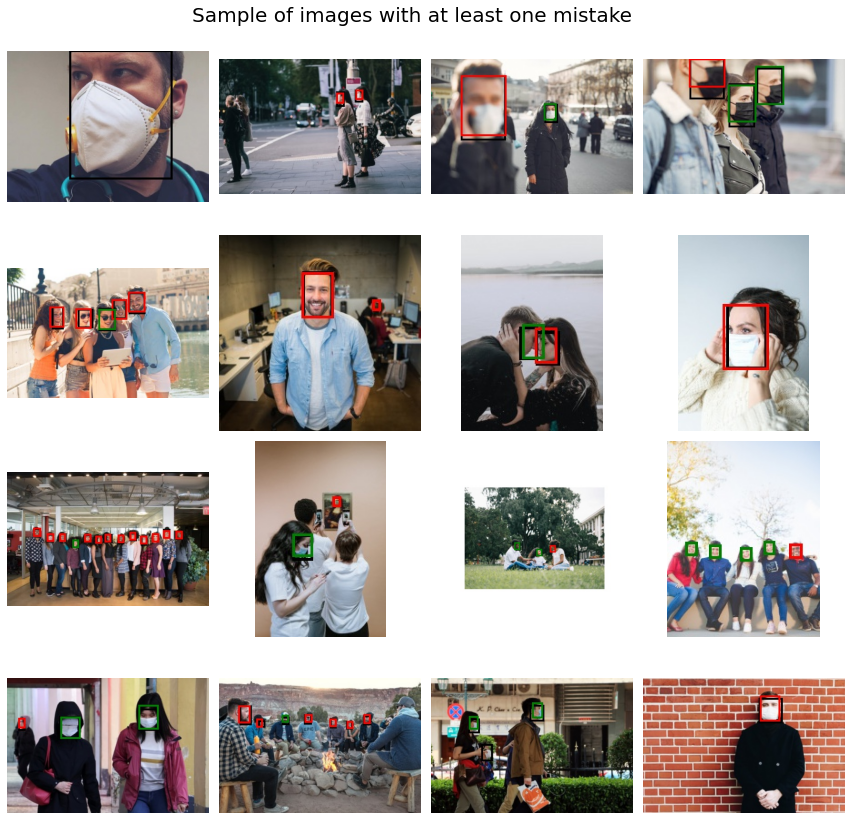

In [27]:
n_to_plot = 16
all_mistake_pred = list(plot_dir_mistake.glob('*.jpg'))
to_plot = random.sample(all_mistake_pred,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with at least one mistake', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()